![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/3.Clinical_Entity_Resolvers.ipynb)

# Clinical Entity Resolvers

## Colab Setup

In [1]:
import json

with open('workshop_license_keys_Aug2020.json') as f_in:
    license_keys = json.load(f_in)

license_keys['JSL_VERSION'] = '2.5.4rc4'

license_keys.keys()

dict_keys(['JSL_VERSION', 'PUBLIC_VERSION', 'SECRET', 'SPARK_NLP_LICENSE', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY', 'JSL_OCR_SECRET', 'SPARK_OCR_LICENSE'])

In [ ]:
# template for license_key.json

{'JSL_VERSION':'jjj',
'PUBLIC_VERSION':'vvv',
'SECRET':"xxx",
'SPARK_NLP_LICENSE': 'aaa',
'JSL_OCR_LICENSE': 'bbb',
'AWS_ACCESS_KEY_ID':"ccc",
'AWS_SECRET_ACCESS_KEY':"ddd",
'JSL_OCR_SECRET':"eee"}

{'AWS_ACCESS_KEY_ID': 'ccc',
 'AWS_SECRET_ACCESS_KEY': 'ddd',
 'JSL_OCR_LICENSE': 'bbb',
 'JSL_OCR_SECRET': 'eee',
 'SPARK_NLP_LICENSE': 'aaa',
 'secret': 'xxx'}

In [ ]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

secret = license_keys['SECRET']

os.environ['SPARK_NLP_LICENSE'] = license_keys['SPARK_NLP_LICENSE']
os.environ['SPARK_OCR_LICENSE'] = license_keys['SPARK_OCR_LICENSE']
os.environ['AWS_ACCESS_KEY_ID']= license_keys['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = license_keys['AWS_SECRET_ACCESS_KEY']
jsl_version = license_keys['JSL_VERSION']
version = license_keys['PUBLIC_VERSION']

! pip install --ignore-installed -q pyspark==2.4.4

! python -m pip install --upgrade spark-nlp-jsl==$jsl_version  --extra-index-url https://pypi.johnsnowlabs.com/$secret

! pip install --ignore-installed -q spark-nlp==$version

import sparknlp

print (sparknlp.version())

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl

spark = sparknlp_jsl.start(secret)

In [ ]:

import sparknlp

print (sparknlp.version())

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl

spark = sparknlp_jsl.start(secret)

In [3]:
sparknlp_jsl.version()

'2.5.4rc4'

In [ ]:
spark

# Clinical Resolvers

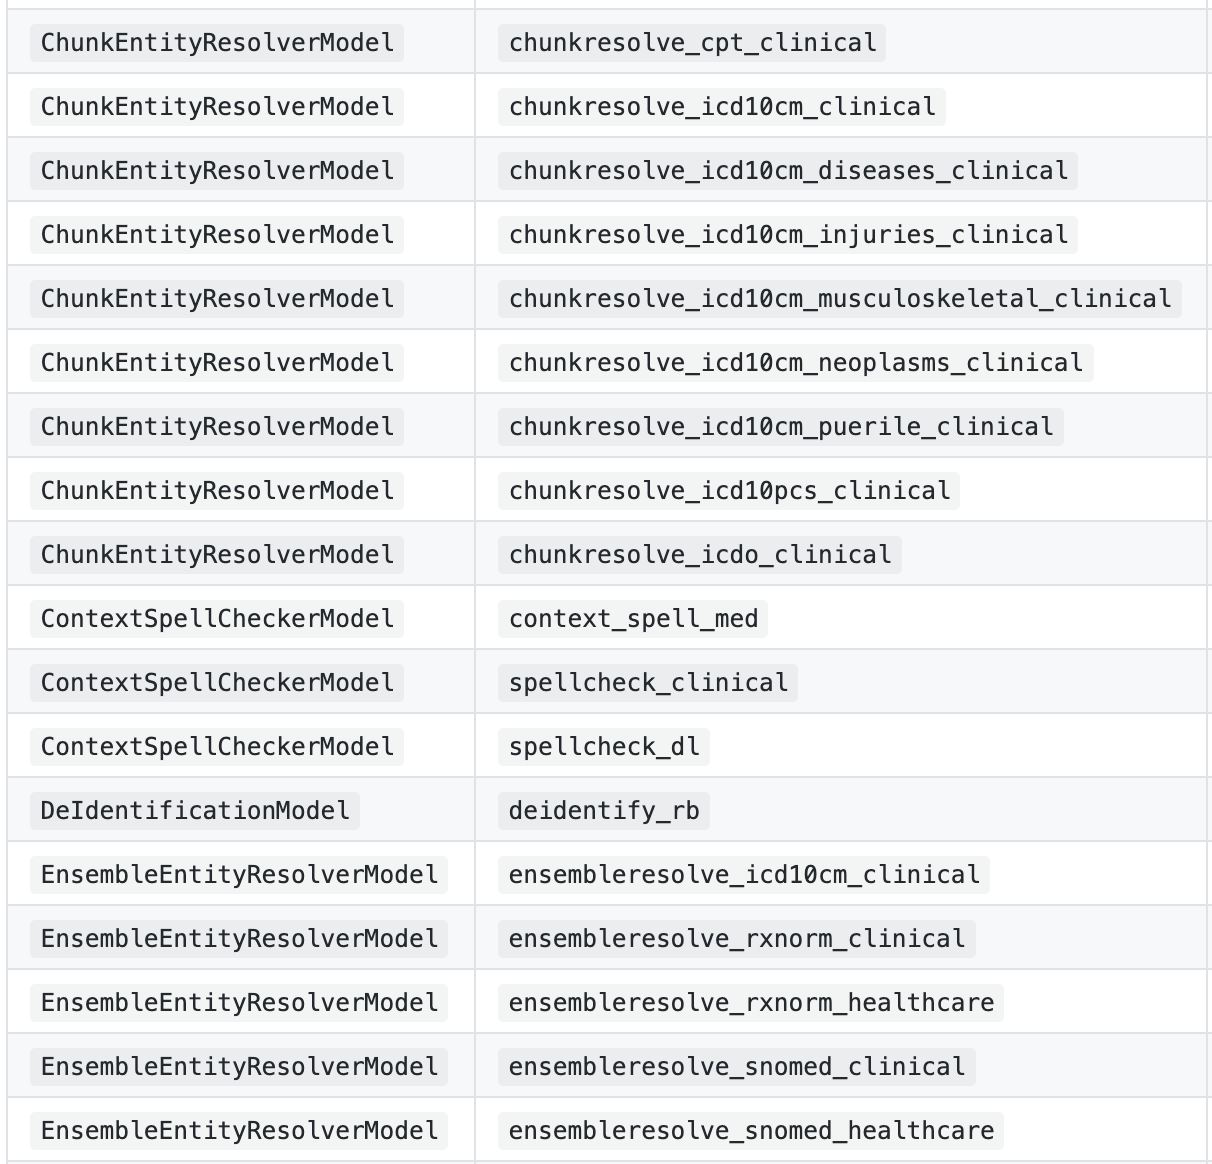

## Entity Resolvers for ICD-10

A common NLP problem in biomedical aplications is to identify the presence of clinical entities in a given text. This clinical entities could be diseases, symptoms, drugs, results of clinical investigations or others.

Other than providing the code in the "result" field it provides more metadata about the matching process:

- target_text -> Text to resolve
- resolved_text -> Best match text
- confidence -> Relative confidence for the top match (distance to probability)
- confidence_ratio -> Relative confidence for the top match. TopMatchConfidence / SecondMatchConfidence
- alternative_codes -> List of other plausible codes (in the KNN neighborhood)
- alternative_confidence_ratios -> Rest of confidence ratios
- all_k_results -> All resolved codes for metrics calculation purposes
- sentence -> SentenceId
- chunk -> ChunkId

In [4]:
import sys, os, time
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.util import *
from sparknlp_jsl.annotator import *

from sparknlp.pretrained import ResourceDownloader

from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel

### Clinical NER Pipeline creation

In [6]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP

documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line

sentenceDetector = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentence")\
  .setCustomBounds([","])

# Tokenizer splits words in a relevant format for NLP

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("raw_token")\
  .setSplitChars([" ",",","\(","\)"])

# Tokenizer splits words in a relevant format for NLP

stopwords = StopWordsCleaner()\
  .setInputCols(["raw_token"])\
  .setOutputCol("token")

The fourth annotator in the pipeline is "WordEmbeddingsModel". We will download a pretrained model available from "clinical/models" named "embeddings_clinical".

When running this cell your are advised to be patient.

First time you call this pretrained model it needs to be downloaded in your local.

The model size is about will download the embeddings_clinical corpus it takes a while.

The size is about 1.7Gb and will be saved typically in your home folder as

`~HOMEFOLDER/cached_models/ embeddings_clinical_en_2.0.2_2.4_1558454742956`

Next times you call it the model is loaded from your cached copy but even in that case it needs to be indexed each time so expect waiting up to 5 minutes (depending on your machine)

In [11]:
# WordEmbeddingsModel pretrained "embeddings_clinical" includes a model of 1.7Gb that needs to be downloaded

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


The fifth and final annotator in our NER pipeline is the pretrained `ner_clinical` NerDLModel avaliable from "clinical/models". It requires as input the "sentence", "token" and "embeddings" (clinical embeddings pretrained model) and will classify each token in four categories:

- PROBLEM: for patient problems

- TEST: for tests, labs, etc.

- TREATMENT: for treatments, medicines, etc.

- OTHER: for the rest of tokens.

In order to split those identified NER that are consecutive, the B prefix (as B-PROBLEM) will be used at the first token of each NER. The I prefix (as I-PROBLEM) will be used for the rest of tokens inside the NER.

In [12]:
# Named Entity Recognition for clinical concepts.

clinical_ner = NerDLModel.pretrained("ner_clinical", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


### Define the NER pipeline

Now we will define the actual pipeline that puts together the annotators we have created.

In [13]:
# Build up the pipeline

pipeline_ner = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    stopwords,
    word_embeddings,
    clinical_ner
  ])

### Create a SparkDataFrame with the content

Now we will create a sample Spark dataframe with our clinical note example.

In this example we are working over a unique clinical note. In production environments a table with several of those clinical notes could be distributed in a cluster and be run in large scale systems.

In [14]:

clinical_note = (
    'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years '
    'prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior '
    'episode of HTG-induced pancreatitis three years prior to presentation, associated '
    'with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, '
    'presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. '
    'Two weeks prior to presentation, she was treated with a five-day course of amoxicillin '
    'for a respiratory tract infection. She was on metformin, glipizide, and dapagliflozin '
    'for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months '
    'at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; '
    'significantly, her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent '
    'laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 20, '
    'creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, glycated hemoglobin (HbA1c) '
    '10%, and venous pH 7.27. Serum lipase was normal at 43 U/L. Serum acetone levels could not be assessed '
    'as blood samples kept hemolyzing due to significant lipemia. The patient was initially admitted for '
    'starvation ketosis, as she reported poor oral intake for three days prior to admission. However, '
    'serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL, the anion gap '
    'was still elevated at 21, serum bicarbonate was 16 mmol/L, triglyceride level peaked at 2050 mg/dL, and '
    'lipase was 52 U/L. The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - '
    'the original sample was centrifuged and the chylomicron layer removed prior to analysis due to '
    'interference from turbidity caused by lipemia again. The patient was treated with an insulin drip '
    'for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL, within '
    '24 hours. Her euDKA was thought to be precipitated by her respiratory tract infection in the setting '
    'of SGLT2 inhibitor use. The patient was seen by the endocrinology service and she was discharged on '
    '40 units of insulin glargine at night, 12 units of insulin lispro with meals, and metformin 1000 mg '
    'two times a day. It was determined that all SGLT2 inhibitors should be discontinued indefinitely. She '
    'had close follow-up with endocrinology post discharge.'
)

data_ner = spark.createDataFrame([[clinical_note]]).toDF("text")

In [ ]:
data_ner.show(truncate = 100)


+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior ...|
+----------------------------------------------------------------------------------------------------+



In [15]:
model = pipeline_ner.fit(data_ner)

### Transform / annotate the clinical note using the model.

In order to process the data with the new created model we have two options.

The first one would be to use the model to transform our clinical note by the command:

`output = model_ner.transform(data_ner)`

That would save in a Spakr DataFrame (output) the resuls of running the model over the clinical note.

However for small tests like this or for real-time request a LightPipelines is a simpler way of managing the data. It will return a dictionary (instead of a Spark DataFrame) with the results of the transformation

We will create a light_pipeline_ner using our model_ner and then will annotate the clinical_note using this light_pipeline.

In [ ]:
light_pipeline = LightPipeline(model)
light_data = light_pipeline.annotate(clinical_note)

Now we have a dictionaty (light_data_ner) that contains the results of running the NER pipeline over our clinical note.

It contains the original document:

In [ ]:
light_data['document'][0][0:100]


'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to '

In [ ]:
print("Number of sentences: {}".format(len(light_data['sentence'])))
print("")
for i in range(5):
    print("Sentence {}: {}".format(i, light_data['sentence'][i][0:80]))

Number of sentences: 46

Sentence 0: A 28-year-old female with a history of gestational diabetes mellitus diagnosed e
Sentence 1: one prior episode of HTG-induced pancreatitis three years prior to presentation
Sentence 2: associated with an acute hepatitis
Sentence 3: and obesity with a body mass index (BMI) of 33.5 kg/m2
Sentence 4: presented with a one-week history of polyuria


In [ ]:
print("Number of tokens: {}".format(len(light_data['token'])))
print("")
for i in range(25):
    print("Token {}: {} ({})".format(i, light_data['token'][i], light_data['ner'][i]))
print("...")

Number of tokens: 265

Token 0: 28-year-old (O)
Token 1: female (O)
Token 2: history (O)
Token 3: gestational (B-PROBLEM)
Token 4: diabetes (I-PROBLEM)
Token 5: mellitus (I-PROBLEM)
Token 6: diagnosed (O)
Token 7: eight (O)
Token 8: years (O)
Token 9: prior (O)
Token 10: presentation (O)
Token 11: subsequent (O)
Token 12: type (B-PROBLEM)
Token 13: two (I-PROBLEM)
Token 14: diabetes (I-PROBLEM)
Token 15: mellitus (I-PROBLEM)
Token 16: T2DM (I-PROBLEM)
Token 17: one (O)
Token 18: prior (O)
Token 19: episode (O)
Token 20: HTG-induced (B-PROBLEM)
Token 21: pancreatitis (I-PROBLEM)
Token 22: three (O)
Token 23: years (O)
Token 24: prior (O)
...


Lets apply some HTML formating to see the results of the pipeline in a nicer layout:



In [ ]:
import random
from IPython.core.display import display, HTML

pallette = {"PROBLEM":(200,50,150),"TEST":(150,200,50),"TREATMENT":(50,150,200)}
def get_color(x):

    return '#%02X%02X%02X' % pallette[x]

def get_NER_html (light_data):

    html_output=''
    
    problem_flag = False
    new_problem = []
    problem_list = []
    
    label_list = list(set([i.split('-')[1] for i in light_data['ner'] if i!='O']))
    
        
    label_color={}
    
    for l in label_list:
        
        label_color[l]=get_color(l)
            
    for index, this_token in enumerate(light_data['token']):

        try:
            ent = light_data['ner'][index].split('-')[1]
        except:
            ent = light_data['ner'][index]
        
       
        if ent in label_list:
            color = label_color[ent]
            html_output+='<SPAN style="background-color: {}">'.format(color) + this_token + " </SPAN>"
        else:
            html_output+=this_token + " "
        

    html_output += '</div>'
    html_output += '<div>Color codes:'
    

    for l in label_list:
        
        html_output += '<SPAN style="background-color: {}">{}</SPAN>, '.format(label_color[l],l)
   
    
    return display(HTML(html_output))


In [ ]:
get_NER_html (light_data)

##  ICD10 background info

ICD-10-CM vs. ICD-10-PCS

With the transition to ICD-10, in the United States, ICD-9 codes are segmented into ICD-10-CM and ICD-10-PCS codes. **The "CM" in ICD-10-CM codes stands for clinical modification**; ICD-10-CM codes were developed by the Centers for Disease Control and Prevention in conjunction with the National Center for Health Statistics (NCHS), for outpatient medical coding and reporting in the United States, as published by the World Health Organization (WHO).

**The "PCS" in ICD-10-PCS codes stands for the procedural classification system**. ICD-10-PCS is a completely separate medical coding system from ICD-10-CM, containing an additional 87,000 codes for use ONLY in United States inpatient, hospital settings. The procedure classification system (ICD-10-PCS) was developed by the Centers for Medicare and Medicaid Services (CMS) in conjunction with 3M Health Information Management (HIM).

ICD-10-CM codes add increased specificity to their ICD-9 predecessors, growing to five times the number of codes as the present system; a total of 68,000 clinical modification diagnosis codes. ICD-10-CM codes provide the ability to track and reveal more information about the quality of healthcare, allowing healthcare providers to better understand medical complications, better design treatment and care, and better comprehend and determine the outcome of care.

ICD-10-PCS is used only for inpatient, hospital settings in the United States, and is meant to replace volume 3 of ICD-9 for facility reporting of inpatient procedures. Due to the rapid and constant state of flux in medical procedures and technology, ICD-10-PCS was developed to accommodate the changing landscape. Common procedures, lab tests, and educational sessions that are not unique to the inpatient, hospital setting have been omitted from ICD-10-PCS.

ICD-10 is confusing enough when you’re trying to digest the differences between ICD-9 and ICD-10, but there are also different types of ICD-10 codes that providers should be aware of.


Primary difference between ICD-10-CM and ICD-10-PCS

When most people talk about ICD-10, they are referring to ICD-10CM. This is the code set for diagnosis coding and is used for all healthcare settings in the United States. ICD-10PCS, on the other hand, is used in hospital inpatient settings for inpatient procedure coding.

ICD-10-CM breakdown

- Approximately 68,000 codes
- 3–7 alphanumeric characters
- Facilitates timely processing of claims


ICD-10-PCS breakdown

- Will replace ICD-9-CM for hospital inpatient use only. 
- ICD-10-PCS will not replace CPT codes used by physicians. According to HealthCare Information Management, Inc. (HCIM), “Its only intention is to identify inpatient facility services in a way not directly related to physician work, but directed towards allocation of hospital services.”

- 7 alphanumeric characters

ICD-10-PCS is very different from ICD-9-CM procedure coding due to its ability to be more specific and accurate. “This becomes increasingly important when assessing and tracking the quality of medical processes and outcomes, and compiling statistics that are valuable tools for research,” according to HCIM.


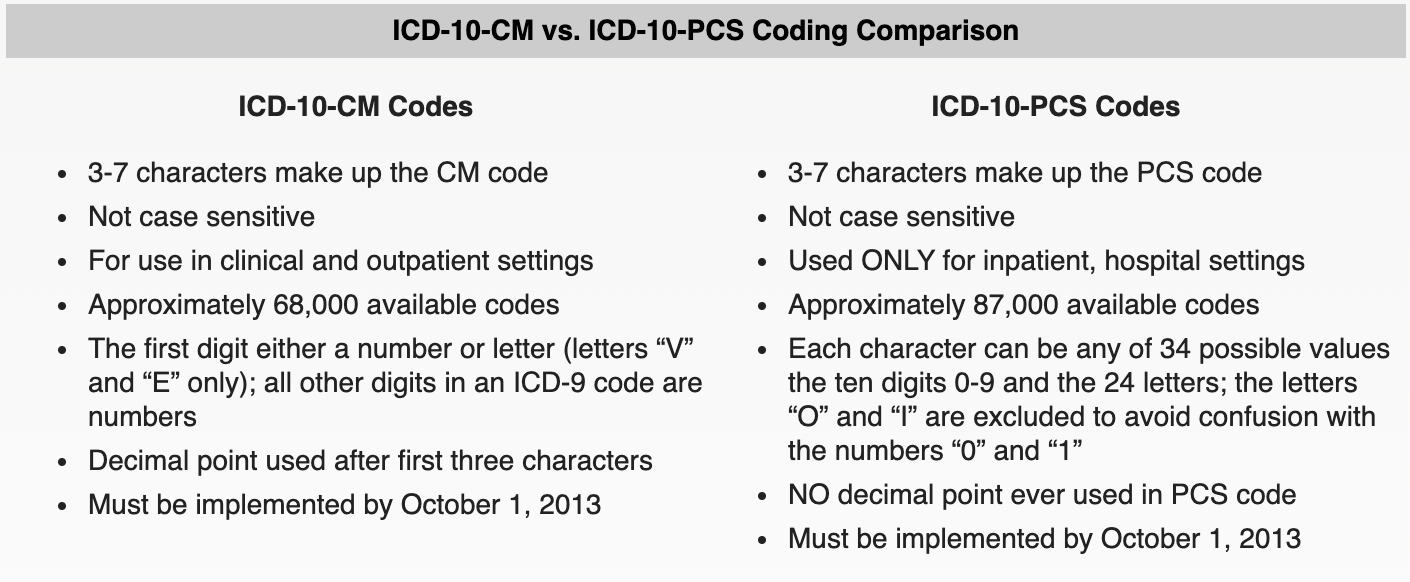


## ICD10 coding Pipeline creation.

We will now create a new pipeline that from each of these problems will try to assign an ICD10 base on the content, the wordembeddings and some pretrained models for ICD10 annotation.

The architecture of this new pipeline will be as follows:

- DocumentAssembler (text -> document)

- SentenceDetector (document -> sentence)

- Tokenizer (sentence -> token)

- WordEmbeddingsModel ([sentence, token] -> embeddings)

- NerDLModel ([sentence, token, embeddings] -> ner)

- NerConverter (["sentence, token, ner] -> ner_chunk

- ChunkTokenizer (ner_chunk -> ner_chunk_tokenized)

- ICD10CMEntityResolverModel ([ner_chunk_tokenized, embeddings] -> resolution)

- ICD10PCSEntityResolverModel ([ner_chunk_tokenized, embeddings] -> resolution)

So from a text we end having a list of Named Entities (ner_chunk) and their ICD10 codes (resolution)

Most of the annotators in this pipeline have been already created for the previous pipeline, but we need to create four additional annotators: NerConverter, ChunkEmbeddigns, EntityResolverModel for ICD10CM and EntityResolverModel for ICD10PCS.

Now we define the new pipeline




In [ ]:
# Named Entity Recognition concepts parser, transforms entities into CHUNKS (required for next step: assertion status)

ner_converter = NerConverterInternal() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")\
  .setWhiteList(['PROBLEM'])\
  .setPreservePosition(False)

chunk_embeddings = ChunkEmbeddings()\
    .setInputCols("ner_chunk", "embeddings")\
    .setOutputCol("chunk_embeddings")

# ICD resolution model

icd10cm_resolution = ChunkEntityResolverModel.pretrained("chunkresolve_icd10cm_clinical", "en", "clinical/models") \
  .setInputCols(["token", "chunk_embeddings"]) \
  .setOutputCol("icd10cm_code") \
  .setDistanceFunction("COSINE")  \#EUCLIDEAN
  .setNeighbours(5)

chunkresolve_icd10cm_clinical download started this may take some time.
Approximate size to download 166.3 MB
[OK!]


`setPreservePosition(True)` takes exactly the original indices (under some tokenization conditions it might include some undesires chars like `")","]"...)`

`setPreservePosition(False)` takes adjusted indices based on substring indexingOf the first (for begin) and last (for end) tokens

also with internal we can use the `greedyMode` which will marge consecutive entities of same type regardless of b-boundaries

In [ ]:

pipeline_icd10 = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    stopwords,
    word_embeddings,
    clinical_ner,
    ner_converter,
    chunk_embeddings,
    icd10cm_resolution
  ])

model_icd10 = pipeline_icd10.fit(data_ner)


In [ ]:
light_pipeline_icd10 = LightPipeline(model_icd10)


In [ ]:
text = light_data['document'][0]

text

'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. Two weeks prior to presentation, she was treated with a five-day course of amoxicillin for a respiratory tract infection. She was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; significantly, her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 2

In [ ]:
import pandas as pd


light_result = light_pipeline_icd10.annotate(text)

df = pd.DataFrame(list(zip(light_result['ner_chunk'], light_result['icd10cm_code'])),
                  columns = ['Problem','ICD10-CM-Code'])

In [ ]:
df.head()

,Problem,ICD10-CM-Code
0,gestational diabetes mellitus,P702
1,type two diabetes mellitus (T2DM,P702
2,HTG-induced pancreatitis,K860
3,associated with an acute hepatitis,B172
4,obesity with a body mass,E661


In [ ]:
def get_icd10_codes (light_model, text):

  full_light_result = light_model.fullAnnotate(text)

  chunks = []
  codes = []
  resolved= []
  begin = []
  end = []
  resolutions=[]

  for chunk, code in zip(full_light_result[0]['ner_chunk'], full_light_result[0]['icd10cm_code']):
          
      begin.append(chunk.begin)
      end.append(chunk.end)
      chunks.append(chunk.result)
      codes.append(code.result) 
      resolutions.append(code.metadata['all_k_resolutions'])
      
  import pandas as pd

  df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                    'icd10_cm_code':codes,
                    'resolutions':resolutions})

  return df




In [ ]:
df = get_icd10_codes (light_pipeline_icd10, text)

df

,chunks,begin,end,icd10_cm_code,resolutions
0,gestational diabetes mellitus,39,67,P702,Neonatal diabetes mellitus:::Type 2 diabetes m...
1,type two diabetes mellitus (T2DM,128,157,P702,Neonatal diabetes mellitus:::Type 2 diabetes m...
2,HTG-induced pancreatitis,184,207,K860,Alcohol-induced chronic pancreatitis:::Cytomeg...
3,associated with an acute hepatitis,244,277,B172,"Acute hepatitis E:::Acute viral hepatitis, uns..."
4,obesity with a body mass,284,307,E661,Drug-induced obesity:::Body mass index (BMI) 2...
5,BMI,314,316,E661,Drug-induced obesity:::Body mass index (BMI) 3...
6,polyuria,373,380,R358,Other polyuria:::Polydipsia:::Generalized edem...
7,polydipsia,383,392,R631,Polydipsia:::Anhedonia:::Galactorrhea
8,poor appetite,395,407,R630,"Anorexia:::Nutritional deficiency, unspecified..."
9,vomiting,414,421,R1114,Bilious vomiting:::Vomiting without nausea:::N...


In [ ]:
output = model_icd10.transform(data_ner).cache()

output.select(F.explode(F.arrays_zip("ner_chunk.result","ner_chunk.metadata",
                                     "icd10cm_code.result","icd10cm_code.metadata")).alias("icd10cm_result")) \
.select(F.expr("icd10cm_result['0']").alias("chunk"),
        F.expr("icd10cm_result['1'].entity").alias("entity"),
        F.expr("icd10cm_result['3'].resolved_text").alias("resolved_text"),
        F.expr("icd10cm_result['2']").alias("code"),
        F.expr("icd10cm_result['3'].all_k_resolutions").alias("cms"))\
.distinct() \
.toPandas()


,chunk,entity,resolved_text,code,cms
0,amoxicillin for a respiratory tract infection,PROBLEM,"Respiratory disorder, unspecified",J989,"Respiratory disorder, unspecified:::Acute naso..."
1,lipemia,PROBLEM,Glycosuria,R81,Glycosuria:::Pure hyperglyceridemia:::Hyperchy...
2,type two diabetes mellitus (T2DM,PROBLEM,Neonatal diabetes mellitus,P702,Neonatal diabetes mellitus:::Type 2 diabetes m...
3,gestational diabetes mellitus,PROBLEM,Neonatal diabetes mellitus,P702,Neonatal diabetes mellitus:::Type 2 diabetes m...
4,benign with no tenderness,PROBLEM,Periumbilic abdominal tenderness,R10815,Periumbilic abdominal tenderness:::Epigastric ...
5,BMI,PROBLEM,Drug-induced obesity,E661,Drug-induced obesity:::Body mass index (BMI) 3...
6,vomiting,PROBLEM,Bilious vomiting,R1114,Bilious vomiting:::Vomiting without nausea:::N...
7,polydipsia,PROBLEM,Polydipsia,R631,Polydipsia:::Anhedonia:::Galactorrhea
8,obesity with a body mass,PROBLEM,Drug-induced obesity,E661,Drug-induced obesity:::Body mass index (BMI) 2...
9,significant for dry oral mucosa,PROBLEM,Irritative hyperplasia of oral mucosa,K136,Irritative hyperplasia of oral mucosa:::Leukop...


In [ ]:
text = 'He has a starvation ketosis but nothing found for significant for dry oral mucosa'

df = get_icd10_codes(light_pipeline_icd10, text)

df

,chunks,begin,end,icd10_cm_code,resolutions
0,starvation ketosis,9,26,E71121,Propionic acidemia:::Bartter's syndrome:::Hypo...
1,significant for dry oral mucosa,50,80,K136,Irritative hyperplasia of oral mucosa:::Leukop...


# RxNorm Resolver

In [ ]:
ner_converter = NerConverterInternal() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("greedy_chunk")\
  .setWhiteList(['TREATMENT'])

chunk_embeddings = ChunkEmbeddings()\
    .setInputCols("greedy_chunk", "embeddings")\
    .setOutputCol("chunk_embeddings")

rxnorm_resolver1 = ChunkEntityResolverModel()\
    .pretrained('chunkresolve_rxnorm_sbd_clinical', 'en', "clinical/models")\
    .setEnableLevenshtein(True)\
    .setNeighbours(200).setAlternatives(5).setDistanceWeights([3,11,0,0,0,9])\
    .setInputCols('token', 'chunk_embeddings')\
    .setOutputCol('rxnorm_resolution')\
    .setPoolingStrategy("MAX")


pipeline_rx = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    stopwords,
    word_embeddings,
    clinical_ner,
    ner_converter,
    chunk_embeddings,
    rxnorm_resolver1
  ])

model_rxnorm = pipeline_rx.fit(data_ner)


chunkresolve_rxnorm_sbd_clinical download started this may take some time.
Approximate size to download 17.9 MB
[OK!]


In [ ]:
output = model_rxnorm.transform(data_ner)

output.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|           raw_token|               token|          embeddings|                 ner|        greedy_chunk|    chunk_embeddings|   rxnorm_resolution|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|A 28-year-old fem...|[[document, 0, 24...|[[document, 0, 16...|[[token, 0, 0, A,...|[[token, 2, 12, 2...|[[word_embeddings...|[[named_entity, 2...|[[chunk, 557, 565...|[[word_embeddings...|[[entity, 557, 56...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----

In [ ]:
output.select(F.explode(F.arrays_zip("greedy_chunk.result","greedy_chunk.metadata","rxnorm_resolution.result","rxnorm_resolution.metadata")).alias("rxnorm_result")) \
    .select(F.expr("rxnorm_result['0']").alias("chunk"),
            F.expr("rxnorm_result['1'].entity").alias("entity"),
            F.expr("rxnorm_result['3'].all_k_resolutions").alias("target_text"),
            F.expr("rxnorm_result['2']").alias("code"),
            F.expr("rxnorm_result['3'].confidence").alias('confidence')).show(truncate = 100)

+-----------------------------------------------+---------+----------------------------------------------------------------------------------------------------+-------+----------+
|                                          chunk|   entity|                                                                                         target_text|   code|confidence|
+-----------------------------------------------+---------+----------------------------------------------------------------------------------------------------+-------+----------+
|                                      metformin|TREATMENT|Metformin hydrochloride 500 MG Oral Tablet [Glucamet]:::Metformin hydrochloride 850 MG Oral Table...| 105376|    0.2067|
|                                      glipizide|TREATMENT|Glipizide 5 MG Oral Tablet [Minidiab]:::Glipizide 5 MG Oral Tablet [Glucotrol]:::Glipizide 5 MG O...| 105373|    0.2224|
|                         dapagliflozin for T2DM|TREATMENT|dapagliflozin 5 MG / saxagliptin 5 MG Ora

In [ ]:
text = 'The patient was prescribed 1 prozac 60mg (oral capsules) for 5 days after meals. He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day.'
text

'The patient was prescribed 1 prozac 60mg (oral capsules) for 5 days after meals. He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day.'

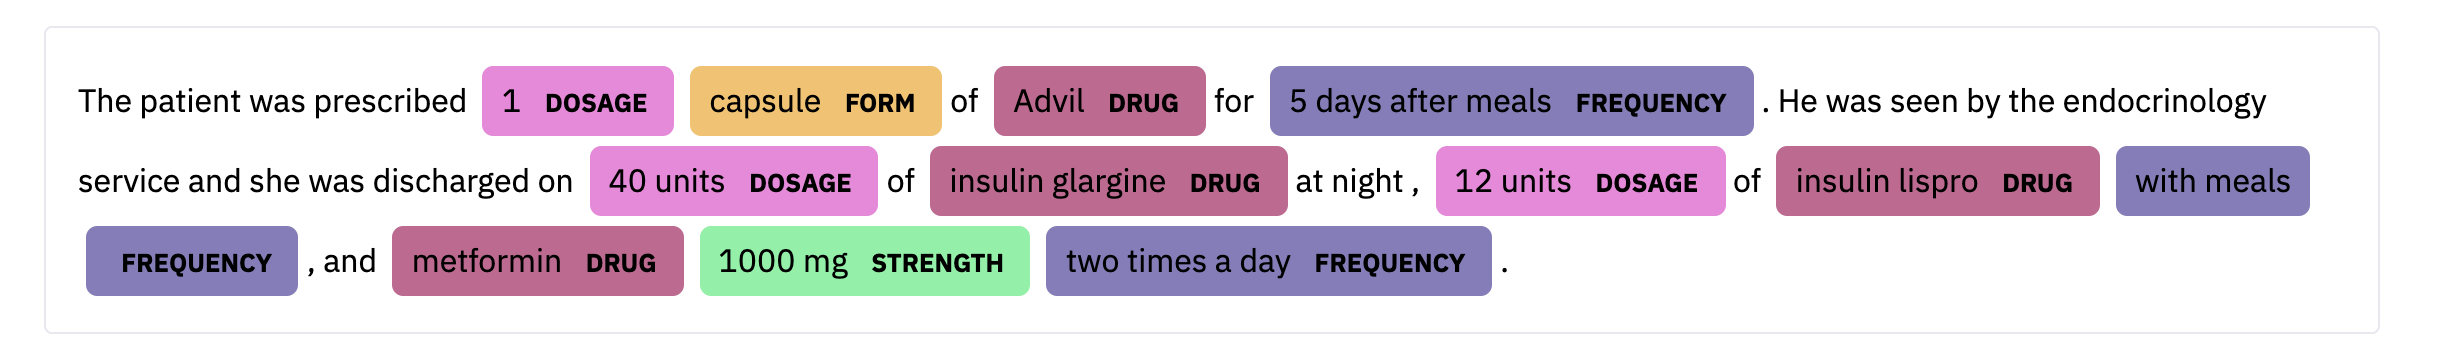

In [ ]:
data_ner = spark.createDataFrame([[text]]).toDF("text")

In [21]:
replace_dict = '''STRENGTH,DRUG
FORM,DRUG
ROUTE,DRUG
DOSAGE,DRUG'''

with open('replace_dict.csv', 'w') as f:
    f.write(replace_dict)

In [ ]:
posology_ner = NerDLModel.pretrained("ner_posology", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_converter1 = NerConverterInternal() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")

chunk_merge = ChunkMergeApproach().setInputCols("ner_chunk","ner_chunk").setOutputCol("merged_chunk")\
  .setReplaceDictResource("replace_dict.csv","TEXT", {"delimiter":","})

iob_tagger = IOBTagger().setInputCols("token","merged_chunk").setOutputCol("merged_ner")

ner_converter2 = NerConverterInternal() \
  .setInputCols(["sentence", "token", "merged_ner"]) \
  .setOutputCol("greedy_chunk")\
  .setPreservePosition(False)\
  .setGreedyMode(True)\
  .setWhiteList(['DRUG'])

posology_rx = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    stopwords,
    word_embeddings,
    posology_ner,
    ner_converter1,
    chunk_merge,
    iob_tagger,
    ner_converter2,
    chunk_embeddings,
    rxnorm_resolver1
  ])

model_rxnorm = posology_rx.fit(data_ner)

output = model_rxnorm.transform(data_ner)

output.select(F.explode(F.arrays_zip("greedy_chunk.result","greedy_chunk.metadata","rxnorm_resolution.result","rxnorm_resolution.metadata")).alias("rxnorm_result")) \
    .select(F.expr("rxnorm_result['0']").alias("chunk"),
            F.expr("rxnorm_result['1'].entity").alias("entity"),
            F.expr("rxnorm_result['3'].all_k_resolutions").alias("target_text"),
            F.expr("rxnorm_result['2']").alias("code"),
            F.expr("rxnorm_result['3'].confidence").alias("confidence")).show(truncate = 100)

ner_posology download started this may take some time.
Approximate size to download 13.7 MB
[OK!]
+----------------------------+------+----------------------------------------------------------------------------------------------------+-------+----------+
|                       chunk|entity|                                                                                         target_text|   code|confidence|
+----------------------------+------+----------------------------------------------------------------------------------------------------+-------+----------+
|  prozac 60mg (oral capsules|  DRUG|Fluoxetine 60 MG Oral Capsule [Prozac]:::Fluoxetine 40 MG Oral Capsule [Prozac]:::Fluoxetine 20 M...| 151261|    0.3328|
|40 units of insulin glargine|  DRUG|1.5 ML Insulin Glargine 300 UNT/ML Pen Injector [Toujeo]:::3 ML Insulin Glargine 100 UNT/ML Pen I...|1604544|    0.2743|
|  12 units of insulin lispro|  DRUG|Insulin Lispro 100 UNT/ML Injectable Solution [Lispro PRC]:::0.5 UNT Doses 

## Pretrained RxNorm Resolver

In [19]:
output = model.transform(data_ner)

In [ ]:
output.columns

['text',
 'document',
 'sentence',
 'raw_token',
 'token',
 'embeddings',
 'ner',
 'ner_chunk',
 'merged_chunk',
 'merged_ner',
 'greedy_chunk',
 'chunk_embeddings',
 'rxnorm_resolution']

In [22]:
posology_ner = NerDLModel.pretrained("ner_posology", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_converter1 = NerConverterInternal() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")

chunk_merge = ChunkMergeApproach().setInputCols("ner_chunk","ner_chunk").setOutputCol("merged_chunk")\
  .setReplaceDictResource("replace_dict.csv","TEXT", {"delimiter":","})

iob_tagger = IOBTagger().setInputCols("token","merged_chunk").setOutputCol("merged_ner")

ner_converter2 = NerConverterInternal() \
  .setInputCols(["sentence", "token", "merged_ner"]) \
  .setOutputCol("greedy_chunk")\
  .setPreservePosition(False)\
  .setGreedyMode(True)\
  .setWhiteList(['DRUG'])

chunk_embeddings = ChunkEmbeddings()\
    .setInputCols("greedy_chunk", "embeddings")\
    .setOutputCol("chunk_embeddings")

rxnorm_resolver1 = ChunkEntityResolverModel()\
    .pretrained('chunkresolve_rxnorm_sbd_clinical', 'en', "clinical/models")\
    .setEnableLevenshtein(True)\
    .setNeighbours(200).setAlternatives(5).setDistanceWeights([3,11,0,0,0,9])\
    .setInputCols('token', 'chunk_embeddings')\
    .setOutputCol('rxnorm_resolution')\
    .setPoolingStrategy("MAX")


posology_rx_pretrained = Pipeline(
    stages = [
    posology_ner,
    ner_converter1,
    chunk_merge,
    iob_tagger,
    ner_converter2,
    chunk_embeddings,
    rxnorm_resolver1
  ])

model_rxnorm_pretrained = posology_rx_pretrained.fit(output)


ner_posology download started this may take some time.
Approximate size to download 13.7 MB
[OK!]
chunkresolve_rxnorm_sbd_clinical download started this may take some time.
Approximate size to download 17.9 MB
[OK!]


In [23]:
model_rxnorm_pretrained.save('saved_model_rxnorm_pretrained')


In [35]:
model_rxnorm_pretrained.save('saved_model_rxnorm_pretrained')

loaded_model_rxnorm_pretrained = PipelineModel.load ('saved_model_rxnorm_pretrained')

In [36]:
posology_rx_pretrained = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    stopwords,
    word_embeddings,
    loaded_model_rxnorm_pretrained
  ])

posology_rxnorm_pretrained = posology_rx_pretrained.fit(data_ner)

pretrained_output = posology_rxnorm_pretrained.transform(data_ner)

pretrained_output.select(F.explode(F.arrays_zip("greedy_chunk.result","greedy_chunk.metadata","rxnorm_resolution.result","rxnorm_resolution.metadata")).alias("rxnorm_result")) \
    .select(F.expr("rxnorm_result['0']").alias("chunk"),
            F.expr("rxnorm_result['1'].entity").alias("entity"),
            F.expr("rxnorm_result['3'].all_k_resolutions").alias("target_text"),
            F.expr("rxnorm_result['2']").alias("code"),
            F.expr("rxnorm_result['3'].confidence").alias("confidence")).show(truncate = 100)

+----------------------------+------+----------------------------------------------------------------------------------------------------+-------+----------+
|                       chunk|entity|                                                                                         target_text|   code|confidence|
+----------------------------+------+----------------------------------------------------------------------------------------------------+-------+----------+
|                 amoxicillin|  DRUG|Amoxicillin 50 MG Oral Tablet [Biomox]:::Amoxicillin 500 MG Oral Capsule [Amix]:::Amoxicillin 250...| 791949|    0.2170|
|                   metformin|  DRUG|Metformin hydrochloride 500 MG Oral Tablet [Glucamet]:::Metformin hydrochloride 850 MG Oral Table...| 105376|    0.2067|
|                   glipizide|  DRUG|Glipizide 5 MG Oral Tablet [Minidiab]:::Glipizide 5 MG Oral Tablet [Glucotrol]:::Glipizide 5 MG O...| 105373|    0.2224|
|               dapagliflozin|  DRUG|dapagliflozin 5

In [33]:
loaded_rxnorm_pretrained = ResourceDownloader.downloadPipeline("ppl_posology_rxnorm","en","clinical/models")

loaded_rxnorm_pretrained.stages

ppl_posology_rxnorm download started this may take some time.
Approx size to download 31.7 MB
[OK!]


[NerDLModel_d6171a6a5d57,
 NerConverterInternal_39d476050b5d,
 MERGE_2274a966f789,
 IOBTagger_c379906d6b22,
 NerConverterInternal_a7b27b5fd264,
 ChunkEmbeddings_8d8fbc62b4fc,
 ENTITY_ae05b6e181aa]

In [34]:
posology_rx_pretrained = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    stopwords,
    word_embeddings,
    loaded_rxnorm_pretrained
  ])

posology_rxnorm_pretrained = posology_rx_pretrained.fit(data_ner)

pretrained_output = posology_rxnorm_pretrained.transform(data_ner)

pretrained_output.select(F.explode(F.arrays_zip("greedy_chunk.result","greedy_chunk.metadata","rxnorm_resolution.result","rxnorm_resolution.metadata")).alias("rxnorm_result")) \
    .select(F.expr("rxnorm_result['0']").alias("chunk"),
            F.expr("rxnorm_result['1'].entity").alias("entity"),
            F.expr("rxnorm_result['3'].all_k_resolutions").alias("target_text"),
            F.expr("rxnorm_result['2']").alias("code"),
            F.expr("rxnorm_result['3'].confidence").alias("confidence")).show(truncate = 100)

+----------------------------+------+----------------------------------------------------------------------------------------------------+-------+----------+
|                       chunk|entity|                                                                                         target_text|   code|confidence|
+----------------------------+------+----------------------------------------------------------------------------------------------------+-------+----------+
|                 amoxicillin|  DRUG|Amoxicillin 50 MG Oral Tablet [Biomox]:::Amoxicillin 500 MG Oral Capsule [Amix]:::Amoxicillin 250...| 791949|    0.2170|
|                   metformin|  DRUG|Metformin hydrochloride 500 MG Oral Tablet [Glucamet]:::Metformin hydrochloride 850 MG Oral Table...| 105376|    0.2067|
|                   glipizide|  DRUG|Glipizide 5 MG Oral Tablet [Minidiab]:::Glipizide 5 MG Oral Tablet [Glucotrol]:::Glipizide 5 MG O...| 105373|    0.2224|
|               dapagliflozin|  DRUG|dapagliflozin 5

# ICD10 + RxNorm with multiple NERs

In [ ]:
notes = [
'Pentamidine 300 mg IV q . 36 hours , Pentamidine nasal wash 60 mg per 6 ml of sterile water q.d . , voriconazole 200 mg p.o . b.i.d . , acyclovir 400 mg p.o . b.i.d . , cyclosporine 50 mg p.o . b.i.d . , prednisone 60 mg p.o . q.d . , GCSF 480 mcg IV q.d . , Epogen 40,000 units subcu q . week , Protonix 40 mg q.d . , Simethicone 80 mg p.o . q . 8 , nitroglycerin paste 1 " ; q . 4 h . p.r.n . , flunisolide nasal inhaler , 2 puffs q . 8 , OxyCodone 10-15 mg p.o . q . 6 p.r.n . , Sudafed 30 mg q . 6 p.o . p.r.n . , Fluconazole 2% cream b.i.d . to erythematous skin lesions , Ditropan 5 mg p.o . b.i.d . , Tylenol 650 mg p.o . q . 4 h . p.r.n . , Ambien 5-10 mg p.o . q . h.s . p.r.n . , Neurontin 100 mg q . a.m . , 200 mg q . p.m . , Aquaphor cream b.i.d . p.r.n . , Lotrimin 1% cream b.i.d . to feet , Dulcolax 5-10 mg p.o . q.d . p.r.n . , Phoslo 667 mg p.o . t.i.d . , Peridex 0.12% , 15 ml p.o . b.i.d . mouthwash , Benadryl 25-50 mg q . 4-6 h . p.r.n . pruritus , Sarna cream q.d . p.r.n . pruritus , Nystatin 5 ml p.o . q.i.d . swish and !',
'Albuterol nebulizers 2.5 mg q.4h . and Atrovent nebulizers 0.5 mg q.4h . , please alternate albuterol and Atrovent ; Rocaltrol 0.25 mcg per NG tube q.d .; calcium carbonate 1250 mg per NG tube q.i.d .; vitamin B12 1000 mcg IM q . month , next dose is due Nov 18 ; diltiazem 60 mg per NG tube t.i.d .; ferrous sulfate 300 mg per NG t.i.d .; Haldol 5 mg IV q.h.s .; hydralazine 10 mg IV q.6h . p.r.n . hypertension ; lisinopril 10 mg per NG tube q.d .; Ativan 1 mg per NG tube q.h.s .; Lopressor 25 mg per NG tube t.i.d .; Zantac 150 mg per NG tube b.i.d .; multivitamin 10 ml per NG tube q.d .; Macrodantin 100 mg per NG tube q.i.d . x 10 days beginning on 11/3/00 .',
'Tylenol 650 mg p.o . q . 4-6h p.r.n . headache or pain ; acyclovir 400 mg p.o . t.i.d .; acyclovir topical t.i.d . to be applied to lesion on corner of mouth ; Peridex 15 ml p.o . b.i.d .; Mycelex 1 troche p.o . t.i.d .; g-csf 404 mcg subcu q.d .; folic acid 1 mg p.o . q.d .; lorazepam 1-2 mg p.o . q . 4-6h p.r.n . nausea and vomiting ; Miracle Cream topical q.d . p.r.n . perianal irritation ; Eucerin Cream topical b.i.d .; Zantac 150 mg p.o . b.i.d .; Restoril 15-30 mg p.o . q . h.s . p.r.n . insomnia ; multivitamin 1 tablet p.o . q.d .; viscous lidocaine 15 ml p.o . q . 3h can be applied to corner of mouth or lips p.r.n . pain control .',
'The patient\'s incisions sternal and right leg were clean and healing well , normal sinus rhythm at 70-80 , with blood pressure 98-110/60 and patient was doing well , recovering , ambulating , tolerating regular diet and last hematocrit prior to discharge was 39% with a BUN and creatinine of 15 and 1.0 , prothrombin time level of 13.8 , chest X-ray prior to discharge showed small bilateral effusions with mild cardiomegaly and subsegmental atelectasis bibasilar and electrocardiogram showed normal sinus rhythm with left atrial enlargement and no acute ischemic changes on electrocardiogram .',
'This is an 82 - year-old male with a history of prior tobacco use , hypertension , chronic renal insufficiency , COPD , gastritis , and TIA who initially presented to Braintree with a non-ST elevation MI and Guaiac positive stools , transferred to St . Margaret\'s Center for Women & Infants for cardiac catheterization with PTCA to mid LAD lesion complicated by hypotension and bradycardia requiring Atropine , IV fluids and transient dopamine possibly secondary to vagal reaction , subsequently transferred to CCU for close monitoring , hemodynamically stable at the time of admission to the CCU .',
'O2 95% on 3L NC mixed Quinn 82% genrl : in nad , resting comfortably heent : perrla ( 4->3 mm ) bilaterally , blind in right visual field , eomi , dry mm , ? thrush neck : no bruits cv : rrr , no m/r/g , faint s1/s2 pulm : cta bilaterally abd : midline scar ( from urostomy ) , nabs , soft , appears distended but patient denies , ostomy RLQ c/d/i , NT to palpation back : right flank urostomy tube , c/d/i , nt to palpation extr : no Gardner neuro : a , ox3 , wiggles toes bilaterally , unable to lift LE , 06-12 grip bilaterally w/ UE , decrease sensation to soft touch in left',
'Is notable for an inferior myocardial infarction , restrictive and obstructive lung disease with an FEV1 of . 9 and FVC of 1.34 and a moderate at best response to bronchodilators , and a negative sestamibi scan in May , 1999 apart from a severe fixed inferolateral defect , systolic dysfunction with recent echocardiography revealing an LVID of 62 mm . and ejection fraction of 28 percent , moderate mitral regurgitation and mild-to-moderate aortic stenosis with a peak gradient of 33 and a mean gradient of 19 and a valve area of 1.4 cm . squared .',
'This is a 47 - year-old male with a past medical history of type 2 diabetes , high cholesterol , hypertension , and coronary artery disease , status post percutaneous transluminal coronary angioplasty times two , who presented with acute coronary syndrome refractory to medical treatment and TNK , now status post Angio-Jet percutaneous transluminal coronary angioplasty and stent of proximal left anterior descending artery and percutaneous transluminal coronary angioplasty of first diagonal with intra-aortic balloon pump placement .',
'Clinical progression of skin and sinus infection on maximal antimicrobial therapy continued , with emergence on November 20 of a new right-sided ptosis in association with a left homonymous hemianopsia , and fleeting confusion while febrile , prompting head MRI which revealed a large 5 x 2 x 4.3 cm region in the right occipital lobe of hemorrhage and edema , with dural and , likely , leptomeningeal enhancement in association with small foci in the right cerebellum and pons , concerning for early lesions of similar type .',
'The patient had an echocardiogram on day two of admission , which revealed a mildly dilated left atrium , mild symmetric LVH , normal LV cavity size , mild region LV systolic dysfunction , arresting regional wall motion abnormality including focal apical hypokinesis , a normal right ventricular chamber size and free wall motion , a moderately dilated aortic root , a mildly dilated ascending aorta , normal aortic valve leaflet , normal mitral valve leaflet and no pericardial effusions .',
'The patient is a 65-year-old man with refractory CLL , status post non-myeloblative stem cell transplant approximately nine months prior to admission , and status post prolonged recent Retelk County Medical Center stay for Acanthamoeba infection of skin and sinuses , complicated by ARS due to medication toxicity , as well as GVHD and recent CMV infection , readmitted for new fever , increasing creatinine , hepatomegaly and fluid surge spacing , in the setting of hyponatremia .',
'Tylenol 650 mg p.o . q.4h . p.r.n . , Benadryl 25 mg p.o . q.h.s . p.r.n . , Colace 100 mg p.o . q.i.d . , Nortriptyline 25 mg p.o . q.h.s . , Simvastatin 10 mg p.o . q.h.s . , Metamucil one packet p.o . b.i.d . p.r.n . , Neurontin 300 mg p.o . t.i.d . , Levsinex 0.375 mg p.o . q.12h . , Lisinopril / hydrochlorothiazide 20/25 mg p.o . q.d . , hydrocortisone topical ointment to affected areas , MS Contin 30 mg p.o . b.i.d . , MSIR 15 to 30 mg p.o . q.4h . p.r.n . pain .',
'Aspirin 325 q.d . ; albuterol nebs 2.5 mg q . 4h ; Colace 100 mg b.i.d . ; heparin 5,000 units subcu b.i.d . ; Synthroid 200 mcg q.d . ; Ocean Spray 2 sprays q . i.d . ; simvastatin 10 mg q . h.s . ; Flovent 220 mcg 2 puffs b.i.d . ; Zantac 150 b.i.d . ; nystatin ointment to the gluteal fold b.i.d . ; Lisinopril 20 mg q.d . ; Mestinon controlled release 180 q . h.s . ; Mestinon 30 mg q . 4h while awake ; prednisone 60 mg p.o . q . IM ; Atrovent nebs 0.5 mg q . i.d .',
'An echocardiogram was obtained on 4-26 which showed concentric left ventricular hypertrophy with normal _____ left ventricular function , severe right ventricular dilatation with septal hypokinesis and flattening with a question of right ventricular apical clot raised with mild aortic stenosis , severe tricuspid regurgitation and increased pulmonary artery pressure of approximately 70 millimeters , consistent with fairly severe pulmonary hypertension .',
'1 ) CV ( R ) finished amio IV load then started on po , agressive lytes ; although interrogation showed >100 episodes of VT ( as / x ) , pt prefers med therapy as opposed to ablation ( I ) enzymes mildly elevated but not actively ischemic ; lipids , ASA , statin , BB ; Adenosine thal 1/4 and echo 1/4 to look for signs of ischemia as active cause for VT ( P ) JVP at angle of jaw 1/4 -- > giving 20 Lasix ; dig level 1/4 1.3 -- > 1/2 dose as on Amio',
'sodium 141 , potassium 3.5 , chloride 107 , bicarbonates 23.8 , BUN 23 , creatinine 1.1 , glucose 165 , PO2 377 , PCO2 32 , PH 7.50 , asomus 298 , toxic screen negative , white blood cell count 11.1 , hematocrit 39.6 , platelet count 137 , prothrombin time 25.2 , INR 4.3 , partial thromboplastin time 34.7 , urinalysis 1+ albumin , 0-5 high link caths , cervical spine negative , pelvis negative , lumbar spine ; negative , thoracic spine negative .',
]

In [ ]:
from IPython.core.display import display, HTML

html_output=""
for i, d in enumerate(notes):
    html_output += f'Note {i}:'
    html_output +='<div style="border:2px solid #747474; background-color: #e3e3e3; margin: 5px; padding: 10px">'
    html_output += d
    html_output += '</div><br/>'

display(HTML(html_output))

In [ ]:
data = spark.createDataFrame([(i,n.lower()) for i,n in enumerate(notes)]).toDF('doc_id', 'text')

data.show(truncate=50)

+------+--------------------------------------------------+
|doc_id|                                              text|
+------+--------------------------------------------------+
|     0|pentamidine 300 mg iv q . 36 hours , pentamidin...|
|     1|albuterol nebulizers 2.5 mg q.4h . and atrovent...|
|     2|tylenol 650 mg p.o . q . 4-6h p.r.n . headache ...|
|     3|the patient's incisions sternal and right leg w...|
|     4|this is an 82 - year-old male with a history of...|
|     5|o2 95% on 3l nc mixed quinn 82% genrl : in nad ...|
|     6|is notable for an inferior myocardial infarctio...|
|     7|this is a 47 - year-old male with a past medica...|
|     8|clinical progression of skin and sinus infectio...|
|     9|the patient had an echocardiogram on day two of...|
|    10|the patient is a 65-year-old man with refractor...|
|    11|tylenol 650 mg p.o . q.4h . p.r.n . , benadryl ...|
|    12|aspirin 325 q.d . ; albuterol nebs 2.5 mg q . 4...|
|    13|an echocardiogram was obtained o

let's build a SparkNLP pipeline with the following stages:

`DocumentAssembler`: Entry annotator for our pipelines; it creates the data structure for the Annotation Framework

`SentenceDetector`: Annotator to pragmatically separate complete sentences inside each document

`Tokenizer`: Annotator to separate sentences in tokens (generally words)

`StopWordsCleaner`: Annotator to remove words defined as StopWords in SparkML

`WordEmbeddings`: Vectorization of word tokens, in this case using word embeddings trained from PubMed, ICD10 and other clinical resources.

`ChunkEmbeddings`: Aggregates the WordEmbeddings for each NER Chunk

`BioNLP NER + NerConverter`: This annotators return Chunks related to Cancer and Genetics diseases

`ChunkEntityResolver`: Annotator that performs search for the KNNs, in this case trained from ICDO Histology Behavior.

In [29]:
# Annotators responsible for the Cancer Genetics Entity Recognition task

jslNer = NerDLModel.pretrained('ner_jsl', 'en', "clinical/models")\
    .setInputCols('sentence', 'token', 'embeddings')\
    .setOutputCol('ner_jsl')

drugNer = NerDLModel.pretrained('ner_drugs', 'en', "clinical/models")\
    .setInputCols('sentence', 'token', 'embeddings')\
    .setOutputCol('ner_drug')

ner_jsl download started this may take some time.
Approximate size to download 14 MB
[OK!]
ner_drugs download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [30]:

#Converter annotators transform IOB tags into full chunks (sequence set of tokens) tagged with `entity` metadata

jslConverter = NerConverter()\
    .setInputCols('sentence', 'token', 'ner_jsl')\
    .setOutputCol('chunk_jsl')\
    .setWhiteList(["Diagnosis"])

drugConverter = NerConverter()\
    .setInputCols('sentence', 'token', 'ner_drug')\
    .setOutputCol('chunk_drug')

In [31]:

#ChunkEmbeddings annotators aggregate embeddings for each token in the chunk

jslChunkEmbeddings = ChunkEmbeddings()\
  .setInputCols('chunk_jsl', 'embeddings')\
  .setOutputCol('chunk_embs_jsl')

drugChunkEmbeddings = ChunkEmbeddings()\
  .setInputCols('chunk_drug', 'embeddings')\
  .setOutputCol('chunk_embs_drug')

In [32]:
# Entity Resolution Pretrained Models

icd10cmResolver2 = ChunkEntityResolverModel.pretrained('chunkresolve_icd10cm_diseases_clinical', 'en', "clinical/models")\
    .setEnableLevenshtein(True)\
    .setNeighbours(200).setAlternatives(5).setDistanceWeights([3,3,2,0,0,7])\
    .setInputCols('token', 'chunk_embs_jsl')\
    .setOutputCol('icd10cm_resolution')

rxnormResolver2 = ChunkEntityResolverModel()\
    .pretrained('chunkresolve_rxnorm_scd_clinical', 'en', "clinical/models")\
    .setEnableLevenshtein(True)\
    .setNeighbours(200).setAlternatives(5).setDistanceWeights([3,3,2,0,0,7])\
    .setInputCols('token', 'chunk_embs_drug')\
    .setOutputCol('rxnorm_resolution')\

chunkresolve_icd10cm_diseases_clinical download started this may take some time.
Approximate size to download 100.7 MB
[OK!]
chunkresolve_rxnorm_scd_clinical download started this may take some time.
Approximate size to download 28.6 MB
[OK!]


In [ ]:
pipelineFull = Pipeline().setStages([
    documentAssembler, 
    sentenceDetector, 
    tokenizer, 
    stopwords, 
    word_embeddings, 
    jslNer,
    drugNer,
    jslConverter,
    drugConverter,
    jslChunkEmbeddings, 
    drugChunkEmbeddings,
    icd10cmResolver2,
    rxnormResolver2
])

In [ ]:
# Persisiting temporarily to keep DAG size and resource usage low (Word Embeddings are Resource Intensive)
pipelineModelFull = pipelineFull.fit(data)

output = pipelineModelFull.transform(data)



In [ ]:
output.write.mode("overwrite").save("temp")

output = spark.read.load("temp")

In [ ]:
%%time
output.show()

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|doc_id|                text|            document|            sentence|           raw_token|               token|          embeddings|             ner_jsl|            ner_drug|           chunk_jsl|          chunk_drug|      chunk_embs_jsl|     chunk_embs_drug|  icd10cm_resolution|   rxnorm_resolution|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     0|pentamidine 300 m...|[[document, 0, 10...|[[document, 0, 24...|[[token, 0, 10, p...

In [ ]:
# lets see what would have happened if we hadn't persisted the pipeline at disk. 
output = pipelineModelFull.transform(data)

In [ ]:
%%time
output.show()
## 1.8 vs 37.7 seconds for the first 20 rows (x20 faster)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|doc_id|                text|            document|            sentence|           raw_token|               token|          embeddings|             ner_jsl|            ner_drug|           chunk_jsl|          chunk_drug|      chunk_embs_jsl|     chunk_embs_drug|  icd10cm_resolution|   rxnorm_resolution|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     0|pentamidine 300 m...|[[document, 0, 10...|[[document, 0, 24...|[[token, 0, 10, p...

In [ ]:
def quick_metadata_analysis(df, doc_field, chunk_field, code_fields):
    code_res_meta = ", ".join([f"{cf}.metadata" for cf in code_fields])
    expression = f"explode(arrays_zip({chunk_field}.begin, {chunk_field}.end, {chunk_field}.result, {chunk_field}.metadata, "+code_res_meta+")) as a"
    top_n_rest = [(f"float(a['{i+4}'].confidence) as {(cf.split('_')[0])}_conf",
                    f"arrays_zip(split(a['{i+4}'].all_k_results,':::'),split(a['{i+4}'].all_k_resolutions,':::')) as {cf.split('_')[0]+'_opts'}")
                    for i, cf in enumerate(code_fields)]
    top_n_rest_args = []
    for tr in top_n_rest:
        for t in tr:
            top_n_rest_args.append(t)
    return df.selectExpr(doc_field, expression) \
        .orderBy('doc_id', F.expr("a['0']"), F.expr("a['1']"))\
        .selectExpr(f"concat_ws('::',{doc_field},a['0'],a['1']) as coords", "a['2'] as chunk","a['3'].entity as entity", *top_n_rest_args)

In [ ]:
icd10cm_analysis = quick_metadata_analysis(output, 'doc_id', 'chunk_jsl',['icd10cm_resolution']).toPandas()

In [ ]:
rxnorm_analysis = \
quick_metadata_analysis(output, 'doc_id', 'chunk_drug',['rxnorm_resolution']).toPandas()

In [ ]:
pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_rows', 500)

In [ ]:
icd10cm_analysis[icd10cm_analysis.icd10cm_conf>0.4]

,coords,chunk,entity,icd10cm_conf,icd10cm_opts
1,2::499::506,insomnia,Diagnosis,0.9050,"[(G4700, Insomnia, unspecified), (G4709, Other insomnia), (F5102, Adjustment insomnia), (F5101, Primary insomnia), (F5109, Other insomnia not due to a substance or known physiological condition)]"
3,4::83::109,chronic renal insufficiency,Diagnosis,0.4048,"[(N185, Chronic kidney disease, stage 5), (N181, Chronic kidney disease, stage 1), (N179, Acute kidney failure, unspecified), (N289, Disorder of kidney and ureter, unspecified), (I255, Ischemic cardiomyopathy)]"
4,4::120::128,gastritis,Diagnosis,0.4680,"[(K2970, Gastritis, unspecified, without bleeding), (B9681, Helicobacter pylori [H. pylori] as the cause of diseases classified elsewhere), (K2900, Acute gastritis without bleeding), (A084, Viral intestinal infection, unspecified), (K2960, Other ..."
6,6::274::293,systolic dysfunction,Diagnosis,0.8329,"[(I519, Heart disease, unspecified), (I5040, Unspecified combined systolic (congestive) and diastolic (congestive) heart failure), (I5020, Unspecified systolic (congestive) heart failure), (N522, Drug-induced erectile dysfunction), (F5221, Male e..."
7,7::78::93,high cholesterol,Diagnosis,0.6277,"[(E789, Disorder of lipoprotein metabolism, unspecified), (E75240, Niemann-Pick disease type A), (E786, Lipoprotein deficiency), (E349, Endocrine disorder, unspecified), (E7211, Homocystinuria)]"
9,7::116::138,coronary artery disease,Diagnosis,0.8401,"[(I2510, Atherosclerotic heart disease of native coronary artery without angina pectoris), (A5206, Other syphilitic heart involvement), (I25810, Atherosclerosis of coronary artery bypass graft(s) without angina pectoris), (I252, Old myocardial in..."
11,9::156::185,region lv systolic dysfunction,Diagnosis,0.8037,"[(I5040, Unspecified combined systolic (congestive) and diastolic (congestive) heart failure), (I519, Heart disease, unspecified), (I501, Left ventricular failure, unspecified), (I5021, Acute systolic (congestive) heart failure), (I5022, Chronic ..."
13,9::345::363,dilated aortic root,Diagnosis,0.9997,"[(I77810, Thoracic aortic ectasia), (G543, Thoracic root disorders, not elsewhere classified), (I350, Nonrheumatic aortic (valve) stenosis), (I77811, Abdominal aortic ectasia), (A5203, Syphilitic endocarditis)]"
14,9::376::398,dilated ascending aorta,Diagnosis,0.8489,"[(I712, Thoracic aortic aneurysm, without rupture), (I77819, Aortic ectasia, unspecified site), (I719, Aortic aneurysm of unspecified site, without rupture), (I728, Aneurysm of other specified arteries), (I700, Atherosclerosis of aorta)]"
16,10::410::445,hepatomegaly and fluid surge spacing,Diagnosis,0.4627,"[(E8779, Other fluid overload), (E860, Dehydration), (E8770, Fluid overload, unspecified), (I313, Pericardial effusion (noninflammatory)), (J811, Chronic pulmonary edema)]"


In [ ]:
rxnorm_analysis[rxnorm_analysis.rxnorm_conf>0.4].head(20)

,coords,chunk,entity,rxnorm_conf,rxnorm_opts
0,0::0::10,pentamidine,DrugChem,0.5925,"[(861601, Pentamidine Isethionate 300 MG Injection), (861597, Pentamidine Isethionate 50 MG/ML Inhalation Solution), (755627, Chloroquine 5 MG/ML Oral Solution), (855624, Dibromopropamidine isethionate 1 MG/ML Ophthalmic Solution), (1119497, chlo..."
1,0::37::47,pentamidine,DrugChem,0.5925,"[(861601, Pentamidine Isethionate 300 MG Injection), (861597, Pentamidine Isethionate 50 MG/ML Inhalation Solution), (755627, Chloroquine 5 MG/ML Oral Solution), (855624, Dibromopropamidine isethionate 1 MG/ML Ophthalmic Solution), (1119497, chlo..."
56,3::278::287,creatinine,DrugChem,0.9996,"[(849628, Creatinine 800 MG Oral Capsule), (252180, Urea 10 MG/ML Topical Lotion), (424168, Urea 30 MG/ML Topical Lotion), (251705, Urea 20 MG/ML Topical Lotion), (245052, Urea 200 MG/ML Oral Solution)]"
59,7::83::93,cholesterol,DrugChem,0.5609,"[(2104173, beta Sitosterol 35 MG Oral Tablet), (832876, phytosterol esters 500 MG Oral Capsule), (637208, phytosterol esters 650 MG Oral Capsule), (411217, Lecithin 228 MG Oral Capsule), (1737442, amphotericin B lipid complex 5 MG/ML Injection)]"
60,10::397::406,creatinine,DrugChem,0.9996,"[(849628, Creatinine 800 MG Oral Capsule), (252180, Urea 10 MG/ML Topical Lotion), (424168, Urea 30 MG/ML Topical Lotion), (251705, Urea 20 MG/ML Topical Lotion), (245052, Urea 200 MG/ML Oral Solution)]"
84,12::328::335,mestinon,DrugChem,0.4385,"[(2099309, moxetumomab pasudotox-tdfk 1 MG Injection), (886677, Clidinium bromide 2.5 MG Oral Capsule), (415693, Heparinoids 0.1 UNT/MG Topical Gel), (204558, Peptide Hydrolases 82 UNT/MG Topical Ointment), (1659998, ANTI-INHIBITOR COAGULANT COMP..."
85,12::372::379,mestinon,DrugChem,0.4385,"[(2099309, moxetumomab pasudotox-tdfk 1 MG Injection), (886677, Clidinium bromide 2.5 MG Oral Capsule), (415693, Heparinoids 0.1 UNT/MG Topical Gel), (204558, Peptide Hydrolases 82 UNT/MG Topical Ointment), (1659998, ANTI-INHIBITOR COAGULANT COMP..."
93,15::73::82,creatinine,DrugChem,0.9996,"[(849628, Creatinine 800 MG Oral Capsule), (252180, Urea 10 MG/ML Topical Lotion), (424168, Urea 30 MG/ML Topical Lotion), (251705, Urea 20 MG/ML Topical Lotion), (245052, Urea 200 MG/ML Oral Solution)]"


## Snomed Resolver

In [ ]:
data.show(3)

+------+--------------------+
|doc_id|                text|
+------+--------------------+
|     0|pentamidine 300 m...|
|     1|albuterol nebuliz...|
|     2|tylenol 650 mg p....|
+------+--------------------+
only showing top 3 rows



In [ ]:

snomed_ner_converter = NerConverterInternal() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("greedy_chunk")\
  .setWhiteList(['PROBLEM','TEST'])

chunk_embeddings = ChunkEmbeddings()\
  .setInputCols('greedy_chunk', 'embeddings')\
  .setOutputCol('chunk_embeddings')

snomed_resolver = \
    ChunkEntityResolverModel.pretrained("chunkresolve_snomed_findings_clinical","en","clinical/models")\
    .setInputCols("token","chunk_embeddings").setOutputCol("snomed_resolution")


pipeline_snomed = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    stopwords,
    word_embeddings,
    clinical_ner,
    snomed_ner_converter,
    chunk_embeddings,
    snomed_resolver
  ])

model_snomed = pipeline_snomed.fit(data)


chunkresolve_snomed_findings_clinical download started this may take some time.
Approximate size to download 162.6 MB
[OK!]


In [ ]:

snomed_output = model_snomed.transform(data)

snomed_output.write.mode("overwrite").save("snomed_temp")

snomed_output = spark.read.load("snomed_temp")

In [ ]:

snomed_output.select(F.explode(F.arrays_zip("greedy_chunk.result","greedy_chunk.metadata","snomed_resolution.result","snomed_resolution.metadata")).alias("snomed_result")) \
    .select(F.expr("snomed_result['0']").alias("chunk"),
            F.expr("snomed_result['1'].entity").alias("entity"),
            F.expr("snomed_result['3'].all_k_resolutions").alias("target_text"),
            F.expr("snomed_result['2']").alias("code"),
            F.expr("snomed_result['3'].confidence").alias("confidence")).show(truncate = 100)

+-----------------------------------------------------------------------------+-------+----------------------------------------------------------------------------------------------------+-----------------+----------+
|                                                                        chunk| entity|                                                                                         target_text|             code|confidence|
+-----------------------------------------------------------------------------+-------+----------------------------------------------------------------------------------------------------+-----------------+----------+
|                                                    erythematous skin lesions|PROBLEM|Skin lesion:::Achromic skin lesions of pinta:::Scaly skin:::Skin constricture:::Cratered skin les...|         95324001|    0.0937|
|                                                                     pruritus|PROBLEM|Pruritus:::Genital pruritus:::Postmenopau